In [1]:
from CCDPApy import CellLine    # used to aggregate all cell lines and experiments data
from CCDPApy import bioprocess_pipeline
from CCDPApy.BioProcess.BioProcess import BioProcess

input_files = ['CL1_1.xlsx', 'CL1_2.xlsx', 'CL1_3.xlsx']
measurement_sheet = 'Measured Data'
feed_sheet = 'Separate Feed Info'
poly_file = 'polynomial_order_1.xlsx'
spc = ['Glucose','Lactate','Glutamine','Asparagine','Aspartate',]
new = ['new']

cell_line = CellLine()

for input in input_files:
    bp = BioProcess(file_name=input,
                    measurement_sheet=measurement_sheet,
                    feed_sheet=feed_sheet,
                    spc_list=spc,
                    #new_spc_list=new
    )
    bp.inprocess(use_feed_conc=True, use_conc_after_feed=False)
    bp.two_pt_calc()
    bp.poly_regression(polyorder_file=poly_file)
    bp.roll_regression(order=3, windows=6)

    cell_line.add_bio_process(bio_process=bp)
cell_line.disp_cell_lines()

CL1_1.xlsx imported.
CL1_2.xlsx imported.
CL1_3.xlsx imported.
Cell Line: Sample CL1
Experiment 1: Sample CL1_1
Experiment 2: Sample CL1_2
Experiment 3: Sample CL1_3


['LACTATE', 'GLUTAMINE', 'ASPARAGINE', 'ASPARTATE']


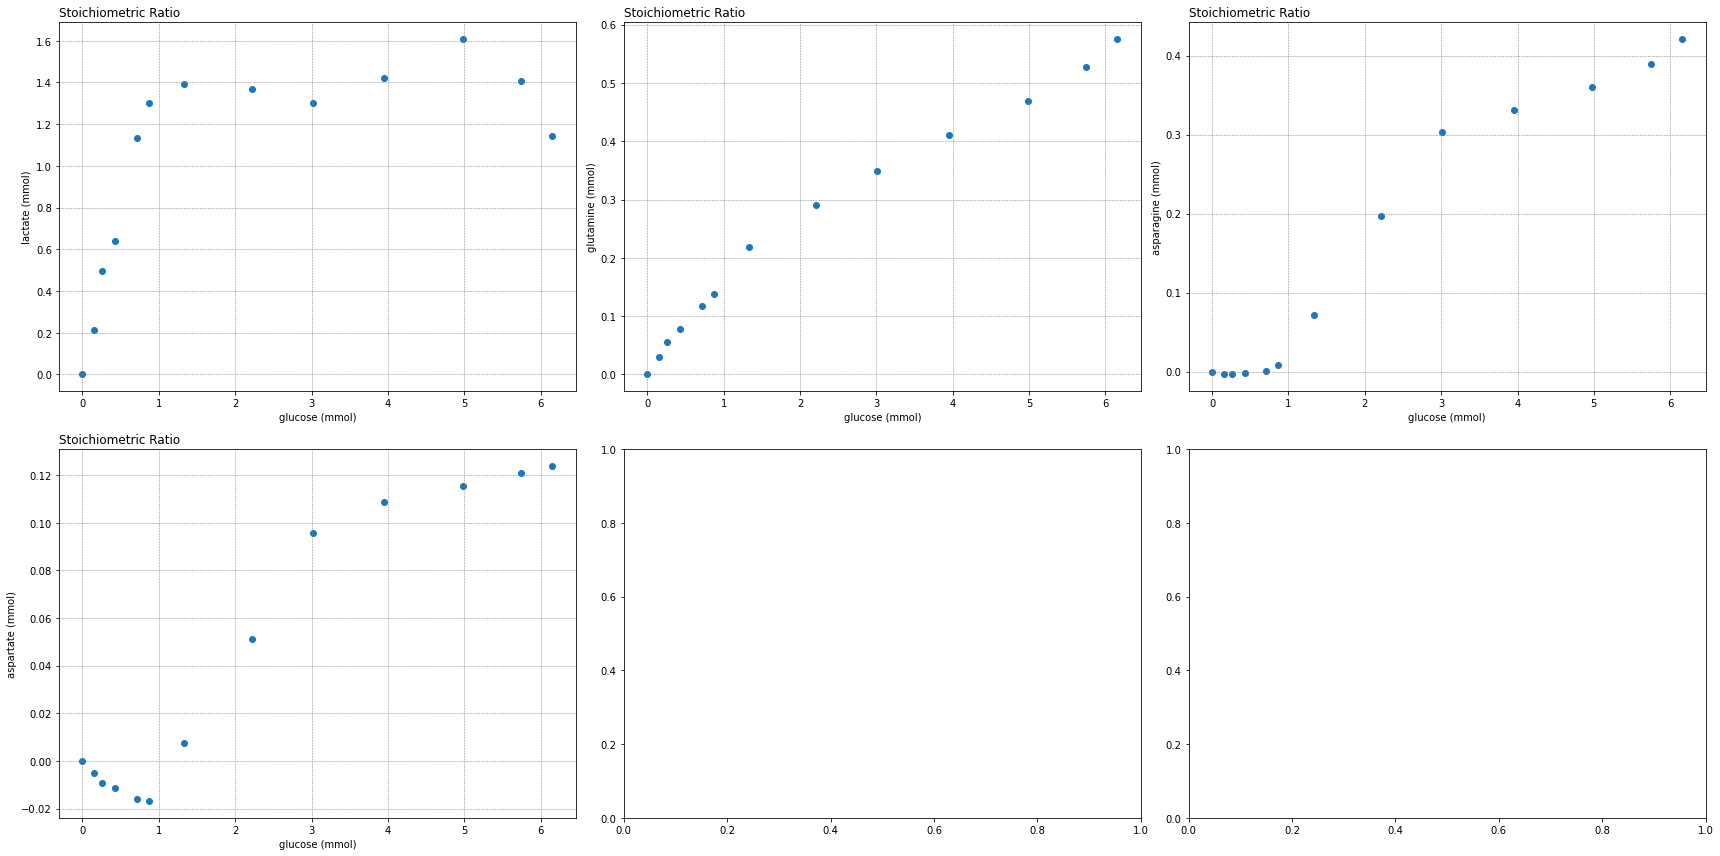

In [10]:
plot_list = 'glutamine'
plot_list = ['Lactate','Glutamine','Asparagine','Aspartate',]
x = 'glutamine'

cl1_1 = cell_line.get_cell_line(cl_name='Sample CL1')['Sample CL1_1']
fig = cl1_1.plot_s_ratio(spc_list=plot_list,
                         #x_spc=x,
                         )

In [ ]:
from CCDPApy import CellLine    # used to aggregate all cell lines and experiments data
from CCDPApy import bioprocess_pipeline # used for data process of one experiment

data_file_1 = ['CL1_1.xlsx', 'CL1_2.xlsx', 'CL1_3.xlsx']
data_file_2 = ['CL2_1.xlsx', 'CL2_2.xlsx', 'CL2_3.xlsx']
data_file_3 = ['CL3_1.xlsx', 'CL3_2.xlsx', 'CL3_3.xlsx']
measurement_sheet = 'Measured Data'
feed_sheet = 'Separate Feed Info'
key_cl1 = {'use_feed_conc': True,
           'use_conc_after_feed': False,
           'spc_list': ['Glucose','Lactate','Glutamine','Asparagine','Aspartate'],
           'polyreg': True, 'polyorder_file': 'polynomial_order_1.xlsx',
           'rollreg': True, 'rollreg_order': 3, 'rollreg_window': 6,
           }

key_cl2 = {'use_feed_conc': False,
           'use_conc_after_feed': True,
           'spc_list': ['Glucose','Lactate','Glutamine','Asparagine','Aspartate'],
           'polyreg': True, 'polyorder_file': 'polynomial_order_2.xlsx',
           'rollreg': True, 'rollreg_order': 3, 'rollreg_window': 6,
           }

key_cl3 = {'use_feed_conc': False,
           'use_conc_after_feed': False,
           'spc_list': ['Glucose','Lactate','Glutamine','Asparagine','Aspartate'],
           'all_method': True
           }
cell_line = CellLine()

for input in data_file_1:
    cl_1 = bioprocess_pipeline(input_file_name=input,
                               measurement_sheet=measurement_sheet,
                               feed_sheet=feed_sheet,
                               **key_cl1)
    cell_line.add_bio_process(bio_process=cl_1)

for input in data_file_2:
    cl_2 = bioprocess_pipeline(input_file_name=input,
                               measurement_sheet=measurement_sheet,
                               feed_sheet=feed_sheet,
                               **key_cl2)
    cell_line.add_bio_process(bio_process=cl_2)


for input in data_file_3:
    cl_3 = bioprocess_pipeline(input_file_name=input,
                               measurement_sheet=measurement_sheet,
                               feed_sheet=feed_sheet,
                               **key_cl3)
    cell_line.add_bio_process(bio_process=cl_3)